In [70]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import pigleg_cv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
!pwd

/webapps/piglegsurgery/piglegcv


In [72]:
import torch
torch.cuda.is_available()

True

In [73]:
!nvidia-smi

Thu Oct 19 14:54:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:42:00.0 Off |                  N/A |
|  0%   43C    P8     9W / 250W |   1930MiB / 11175MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [74]:
torch.__version__

'1.12.0a0+8a1a93a'

In [75]:
Path("/root/.cache/torch/hub/checkpoints/").exists()

True

In [76]:
!ls /root/.cache/torch/hub/checkpoints/

yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth


In [48]:
# pip install mmcv-full

# Run whole video processing

In [84]:
patch = "*/Anasto*.mp4"
patch = "*/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov"


img_pths = list(Path("../piglegsurgeryweb/media/upload/").glob(patch))
img_pths[0]

PosixPath('../piglegsurgeryweb/media/upload/20231012-094422_2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht_939b8c1a12d580345efe250b4ce434bf5a3fa6c8/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov')

2023-10-19 16:43:58.117 | INFO     | pigleg_cv:run:59 - CV processing started on ../piglegsurgeryweb/media/upload/20231012-094422_2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht_939b8c1a12d580345efe250b4ce434bf5a3fa6c8/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov, outputdir=del_test_video_output
2023-10-19 16:43:58.119 | DEBUG    | pigleg_cv:run_video_processing:93 - Running video processing...
2023-10-19 16:43:58.151 | DEBUG    | run_perpendicular:get_frame_to_process:162 - 14262
2023-10-19 16:43:58.304 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 16:43:58.397 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 16:43:58.489 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 16:43:58.582 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 16:43:58.677 | DEBUG  

Fusing layers... 
IDetect.fuse


2023-10-19 16:44:01.722 | DEBUG    | pigleg_cv:do_crop_rotate_rescale:208 - filename=../piglegsurgeryweb/media/upload/20231012-094422_2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht_939b8c1a12d580345efe250b4ce434bf5a3fa6c8/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov, True
2023-10-19 16:44:01.724 | DEBUG    | pigleg_cv:do_crop_rotate_rescale:213 - ffmpeg -i ../piglegsurgeryweb/media/upload/20231012-094422_2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht_939b8c1a12d580345efe250b4ce434bf5a3fa6c8/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov -t 3 -filter:v crop=1522:1669:27:0,scale=720:trunc(ow/a/2)*2 -an -y -b:v 1000k del_test_video_output/__cropped.mp4
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd

Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2023-10-19 16:44:04,445 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - number of detected incisions = 0
2023-10-19 16:44:04.447 | DEBUG    | run_perpendicular:main_perpendicular:293 - len(imgs)=0
2023-10-19 16:44:04.449 | DEBUG    | pigleg_cv:run_image_processing:82 - Perpendicular finished.
2023-10-19 16:44:04.450 | DEBUG    | pigleg_cv:run_video_processing:116 - Single frame processing on cropped mediafile finished in 1.2281267642974854s.
2023-10-19 16:44:04.451 | DEBUG    | pigleg_cv:run_video_processing:118 - Image processing finished in 1.2296512126922607s.
2023-10-19 16:44:05,688 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-10-19 16:44:05,715 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-10-19 16:44:0

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack/epoch.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_backbone_stage1

2023-10-19 16:44:21.505 | DEBUG    | pigleg_cv:run_video_processing:129 - Tracker finished in 17.052497625350952s.
2023-10-19 16:44:21.507 | DEBUG    | pigleg_cv:run_video_processing:131 - filename=del_test_video_output/__cropped.mp4, outputdir=del_test_video_output
2023-10-19 16:44:21.509 | DEBUG    | pigleg_cv:run_video_processing:132 - filename=True, outputdir=True
2023-10-19 16:44:21.514 | DEBUG    | run_report:main_report:673 - size_input_video: [720, 788], size_output_video: [938, 420], size_output_img: [383, 420], resize_factor: 0.5329949238578681
2023-10-19 16:44:21.516 | DEBUG    | run_report:main_report:692 - Sort data N=
/webapps/piglegsurgery/piglegcv/run_report.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frame_ids_list = np.asarray(frame_ids).to

r Forceps


2023-10-19 16:44:22.554 | DEBUG    | run_report:main_report:757 - Frame 10 processed!
2023-10-19 16:44:23.455 | DEBUG    | run_report:main_report:757 - Frame 20 processed!
2023-10-19 16:44:24.338 | DEBUG    | run_report:main_report:757 - Frame 30 processed!
2023-10-19 16:44:25.221 | DEBUG    | run_report:main_report:757 - Frame 40 processed!
2023-10-19 16:44:26.104 | DEBUG    | run_report:main_report:757 - Frame 50 processed!
2023-10-19 16:44:26.978 | DEBUG    | run_report:main_report:757 - Frame 60 processed!
2023-10-19 16:44:27.843 | DEBUG    | run_report:main_report:757 - Frame 70 processed!
2023-10-19 16:44:28.728 | DEBUG    | run_report:main_report:757 - Frame 80 processed!
2023-10-19 16:44:29.625 | DEBUG    | run_report:main_report:757 - Frame 90 processed!
2023-10-19 16:44:30.521 | DEBUG    | run_report:main_report:757 - Frame 100 processed!
2023-10-19 16:44:31.409 | DEBUG    | run_report:main_report:757 - Frame 110 processed!
2023-10-19 16:44:32.296 | DEBUG    | run_report:main

main_report: Video file del_test_video_output/__cropped.mp4 is processed!


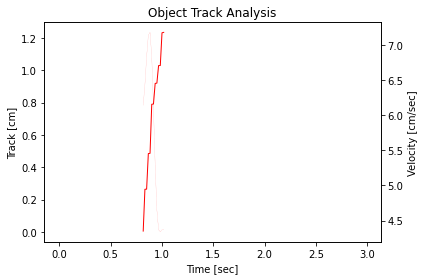

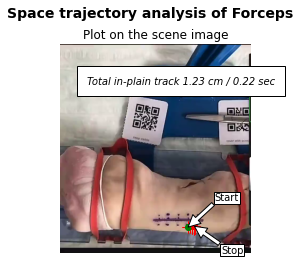

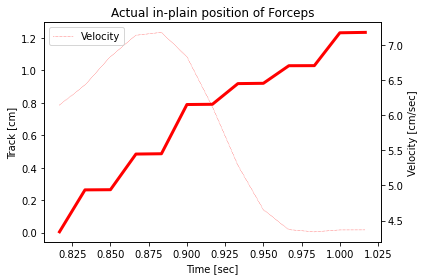

In [86]:
outputdir = "./del_test_video_output/"
# pigleg_cv.do_computer_vision(img_pths[0], outputdir , meta=None)
dcv = pigleg_cv.DoComputerVision(img_pths[0], outputdir, test_first_seconds=True)
dcv.run()

# Do it per partes

2023-10-19 14:48:34.625 | DEBUG    | run_perpendicular:get_frame_to_process:162 - 14262
2023-10-19 14:48:34.785 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 14:48:34.888 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 14:48:34.987 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 14:48:35.078 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 14:48:35.172 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 14:48:35.270 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 14:48:35.366 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame
2023-10-19 14:48:35.461 | DEBUG    | run_perpendicular:get_frame_to_process:171 - Last frame capture error, frame


Fusing layers... 
IDetect.fuse


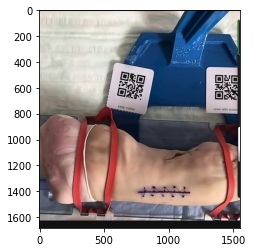

In [67]:

qr_data = dcv.get_parameters_for_crop_rotate_rescale()
plt.imshow(dcv.frame[:,:,::-1])

2023-10-19 14:49:13.677 | DEBUG    | pigleg_cv:do_crop_rotate_rescale:171 - self.filename_cropped=del_test_video_output/__cropped.mp4
2023-10-19 14:49:13.680 | DEBUG    | pigleg_cv:do_crop_rotate_rescale:198 - filename=../piglegsurgeryweb/media/upload/20231012-094422_2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht_939b8c1a12d580345efe250b4ce434bf5a3fa6c8/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov, True
2023-10-19 14:49:13.681 | DEBUG    | pigleg_cv:do_crop_rotate_rescale:203 - ffmpeg -i ../piglegsurgeryweb/media/upload/20231012-094422_2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht_939b8c1a12d580345efe250b4ce434bf5a3fa6c8/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov -t 10 -filter:v crop=1522:1669:27:0,scale=720:trunc(ow/a/2)*2 -an -y -b:v 1000k del_test_video_output/__cropped.mp4
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/u

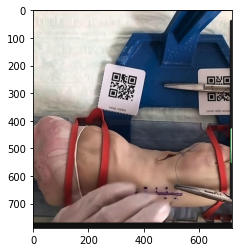

In [69]:
fn = dcv.do_crop_rotate_rescale(qr_data["bbox_scene_area"], qr_data["incision_bboxes"])
img = pigleg_cv.get_frame_to_process(fn)
plt.imshow(img[:,:,::-1])

In [32]:

# pigleg_cv.do_computer_vision(img_pths[0],  "./del_test_video_output/", meta=None)
pigleg_cv.main_report(str(img_pths[0]),  outputdir)

TypeError: main_report() missing 1 required positional argument: 'meta'

In [13]:
import os.path
import json
import pandas as pd
from tools import flatten_dict, remove_empty_lists

novy = {
}

filename = Path(outputdir) / "meta.json"
if os.path.isfile(filename):
    with open(filename, 'r') as fr:
        data = json.load(fr)
        novy.update(data)

# filename = Path(serverfile.outputdir) / "evaluation.json"
filename = Path(outputdir) / "results.json"
if os.path.isfile(filename):
    with open(filename, 'r') as fr:
        data = json.load(fr)
        novy.update(data)

In [ ]:
nnovy = remove_empty_lists(flatten_dict(novy))
print(nnovy)

In [17]:
df_novy = pd.DataFrame(nnovy, index=[0])
df_novy

ValueError: could not broadcast input array from shape (5,) into shape (1,)

{'qr_data_pix_size_method': 'video size estimation', 'qr_data_is_detected': False, 'qr_data_pix_size': 1.0, 'qr_data_qr_size': 0.027, 'qr_data_size_by_scene': 0.0003125, 'qr_data_text': None, 'qr_data_pix_size_single_frame_detector_m': 4.3181322072354286e-05, 'qr_data_bbox_scene_area': [0.0, 2.399106502532959, 922.3617553710938, 536.9542846679688, 0.39207544922828674], 'qr_data_qr_scissors_frame_detected': False, 'pixelsize_m_by_incision_size': 0.0003333333333333334, 'incision_bboxes': [[283.20086669921875, 304.21234130859375, 493.01824951171875, 359.9990539550781, 0.9942836165428162]], 'Needle holder length [m]': 0.24053719983441682, 'Needle holder visibility [s]': 6.640000000000001, 'Needle holder velocity': 0.03312547836389318, 'Needle holder unit': 'm', 'Needle holder visibility [%]': 89.72972972972973, 'Scissors length [m]': 0.03736967463743802, 'Scissors visibility [s]': 5.640000000000001, 'Scissors velocity': 0.004123953506962486, 'Scissors unit': 'm', 'Scissors visibility [%]':

In [ ]:
!python /home/appuser/mmdetection/mmdet/utils/collect_env.py

In [ ]:
!pwd

In [ ]:
pip list

In [ ]:
# !MMCV_WITH_OPS=1 FORCE_CUDA=1 pip install mmcv-full==1.5.2

In [ ]:
# !pip uninstall -y mmcv-full